
# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Relevant Material

- Tutorial 3
- Huggingface documentation
- Huggingface hub

# Introduction

You are tasked to address the [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.

## Problem definition

Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Sexist

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the binary classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)


### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code.

- Type your token and press Enter
- You can say No to Github linking

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `fra_token` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `fra_toke

After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading

Since we are only interested in prompting, we do not require a train dataset.

We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).

Check the ``Assignment 2/data`` folder.
It contains:

- ``a2_test.csv`` → a small test set of 300 samples.
- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.

Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions

We require you to:

* **Download** the ``A2/data`` folder.
* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

Importing useful libraries


In [ ]:
import os
import requests
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import zipfile
import numpy as np
from tqdm import tqdm
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay, classification_report
from IPython.display import display, HTML
from wordcloud import WordCloud
from collections import Counter
import warnings
from transformers import BitsAndBytesConfig
import torch


warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# system packages
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from pathlib import Path
import shutil
import urllib
import tarfile

!pip install transformers
!pip install datasets
!pip install accelerate -U
!pip install evaluate
!pip install bitsandbytes
from transformers import BitsAndBytesConfig
import torch
torch.cuda.is_available()

!nvidia-smi

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 2560,
        'height': 1440,
        'scroll': True,
})

Tue Jan  7 10:17:37 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               8W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

{'width': 2560, 'height': 1440, 'scroll': True}

We downloaded the A2/data folder and we encoded it in a Pandas.Dataframes object

In [ ]:
base_url = "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/"
json_files = ["a2_test.csv", "demonstrations.csv"]
local_dir = Path("Assignment2/data")
local_dir.mkdir(parents=True, exist_ok=True)

# Download each file
for file_name in json_files:
    url = base_url + file_name
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_dir / file_name, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}")

# Load JSON files into pandas DataFrames
dataframes = {}
for file_name in json_files:
    with open(local_dir / file_name, "r") as file:
        dataframes[file_name] = pd.read_csv(file)

Downloaded a2_test.csv
Downloaded demonstrations.csv


In [ ]:
test_data = dataframes['a2_test.csv']
print(f"Shape of the test data: {test_data.shape}")


Shape of the test data: (300, 3)


In [ ]:
test_data.head()

,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,not sexist
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,sexist
2,sexism2022_english-3018,Old man mogs everyone in this sub,not sexist
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",not sexist
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,sexist


# [Task 1 - 0.5 points] Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware

## Which LLMs?

The pool of LLMs is ever increasing and it's impossible to keep track of all new entries.

We focus on popular open-source models.

- [Mistral v2](mistralai/Mistral-7B-Instruct-v0.2)
- [Mistral v3](mistralai/Mistral-7B-Instruct-v0.3)
- [Llama v3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)
- [Phi3-mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct)

Other open-source models are more than welcome!

### Instructions

In order to get Task 1 points, we require you to:

* Pick 2 model cards from the provided list.
* For each model:
  - Define a separate section of your notebook for the model.
  - Setup a quantization configuration for the model.
  - Load the model via HuggingFace APIs.


### Notes

1. There's a popular library integrated with Huggingface's ``transformers`` to perform quantization.

2. Define two separate sections of your notebook to show that you have implemented the prompting pipeline for each selected model card.

## **PHI-3-mini**

In [ ]:
model_card_PHI = "microsoft/Phi-3-mini-4k-instruct"

tokenizer_PHI = AutoTokenizer.from_pretrained(model_card_PHI)
tokenizer_PHI.pad_token = tokenizer_PHI.eos_token

terminators = [
    tokenizer_PHI.eos_token_id,
    tokenizer_PHI.convert_tokens_to_ids("<|eot_id|>")]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_PHI = AutoModelForCausalLM.from_pretrained(
    model_card_PHI,
    return_dict=True,
    quantization_config=bnb_config,
    device_map='auto'
)

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [ ]:
generation_config_PHI = model_PHI.generation_config
generation_config_PHI.max_new_tokens = 100
generation_config_PHI.eos_token_id = tokenizer_PHI.eos_token_id
generation_config_PHI.pad_token_id = tokenizer_PHI.eos_token_id
generation_config_PHI.temperature = None
generation_config_PHI.num_return_sequences = 1

## **MISTRAL V3**


In [ ]:
model_card_MISTRAL = "mistralai/Mistral-7B-Instruct-v0.3"


tokenizer_MISTRAL = AutoTokenizer.from_pretrained(model_card_MISTRAL)
tokenizer_MISTRAL.pad_token = tokenizer_MISTRAL.eos_token

terminators = [
    tokenizer_MISTRAL.eos_token_id,
    tokenizer_MISTRAL.convert_tokens_to_ids("<|eot_id|>")]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_MISTRAL = AutoModelForCausalLM.from_pretrained(
    model_card_MISTRAL,
    return_dict=True,
    quantization_config=bnb_config,
    device_map='auto'
)

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
generation_config_MISTRAL = model_MISTRAL.generation_config
generation_config_MISTRAL.max_new_tokens = 100
generation_config_MISTRAL.eos_token_id = tokenizer_MISTRAL.eos_token_id
generation_config_MISTRAL.pad_token_id = tokenizer_MISTRAL.eos_token_id
generation_config_MISTRAL.temperature = None
generation_config_MISTRAL.num_return_sequences = 1

# [Task 2 - 1.0 points] Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


## Prompt Template

Use the following prompt template to process input texts.

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

### Instructions

In order to get Task 2 points, we require you to:

* Write a ``prepare_prompts`` function as the one reported below.

In the following function we decided to return the non-tokenized prompts beacuse in the generate_responses function we use the function Pipeline from Transformers which was suggested in the Hugginface documentation.

In [ ]:
def prepare_prompts(texts, prompt_template):
    """
    This function format input text samples into instruction prompts.

    Inputs:
      texts: list of input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment


    Outputs:
      prompts: list of instruction prompts
    """
    prompts = []
    for text in texts:
        current_prompt = [
            {
                'role': entry['role'],
                'content': entry['content'].format(text=text) if '{text}' in entry['content'] else entry['content']
            }
            for entry in prompt_template
        ]
        prompts.append(current_prompt)


    return prompts

### Notes

1. You are free to modify the prompt format (**not its content**) as you like depending on your code implementation.

2. Note that the provided prompt has placeholders. You need to format the string to replace placeholders. Huggingface might have dedicated APIs for this.

# [Task 3 - 1.0 points] Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

### Instructions

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

In [ ]:
def generate_responses(model, prompt_examples, tokenizer):
    """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: pre-processed text samples
      tokenizer: tokenizer to be used for the model

    Outputs:
      generated responses
    """
    # Set up the pipeline
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.bfloat16,
        device_map="auto",
    )

    # Create a list to store generated responses
    sequences = []

    for prompt in tqdm(prompt_examples, desc="Generating Responses", unit="example"):
        response = pipe(prompt, max_new_tokens=100)
        sequences.append(response)

    return sequences


In [ ]:
def process_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed binary response: return 1 if YES and 0 if NO
  """

  answer = response[0]['generated_text'][-1]['content']
  normalized_response = answer.strip().upper()
# A failed example is considered a response that does not contain either "YES" or "NO" within it.
# A response such as "YES + explanation" falls under the category of "YES."
  if "YES" in normalized_response:
      return 1, 0  # Return 1 for "YES", no failure
  elif "NO" in normalized_response:
      return 0, 0  # Return 0 for "NO", no failure
  else:
      return 0, 1  # Return 0 for invalid response, mark as failure

## **GENERATING RESPONSES PHI**

In [ ]:
#PHI MODEL
prepared_prompts_PHI = prepare_prompts(test_data['text'], prompt)
responses_PHI = generate_responses(model_PHI, prepared_prompts_PHI, tokenizer_PHI)

Device set to use cuda:0
Generating Responses: 100%|██████████| 300/300 [03:18<00:00,  1.51example/s]


## **GENERATING RESPONSES MISTRAL**


In [ ]:
# MISTRAL MODEL
prepared_prompts_MISTRAL = prepare_prompts(test_data['text'], prompt)
responses_MISTRAL = generate_responses(model_MISTRAL, prepared_prompts_MISTRAL, tokenizer_MISTRAL)

Device set to use cuda:0
Generating Responses: 100%|██████████| 300/300 [05:59<00:00,  1.20s/example]


## Notes

1. According to our tests, it should take you ~10 mins to perform full inference on 300 samples.

# [Task 4 - 0.5 points] Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models.

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

### Instructions

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

In [ ]:
def compute_metrics(responses, y_true):
    """
    This function takes predicted and ground-truth labels and compute metrics.
    In particular, this function computes accuracy, fail-ratio metrics, and identifies wrong responses.
    This function internally invokes `process_response` to compute metrics.

    Inputs:
      responses: generated LLM responses
      y_true: ground-truth binary labels

    Outputs:
      dictionary containing desired metrics, including wrong responses
    """
    # Process responses to convert them into binary predictions
    y_pred, fails = zip(*[process_response(response) for response in responses])

    # Identify wrong responses
    wrong_responses = [idx for idx, (pred, true) in enumerate(zip(y_pred, y_true)) if pred != true]

    accuracy = sum(1 for pred, true in zip(y_pred, y_true) if pred == true) / len(y_true)
    fail_ratio = sum(fails) / len(y_true)
    # Precision, recall, and F1 score calculations
    true_positives = sum(1 for pred, true in zip(y_pred, y_true) if pred == true == 1)
    false_positives = sum(1 for pred, true in zip(y_pred, y_true) if pred == 1 and true == 0)
    false_negatives = sum(1 for pred, true in zip(y_pred, y_true) if pred == 0 and true == 1)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "accuracy": accuracy,
        "fail_ratio": fail_ratio,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "wrong_responses": wrong_responses
    }

In [ ]:
def print_metrics(metrics):
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Fail Ratio: {metrics['fail_ratio']}")


## **METRICS PHI**

In [ ]:
metrics_PHI = compute_metrics(responses_PHI, test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0))
print_metrics(metrics_PHI)


Accuracy: 0.64
Fail Ratio: 0.0


## **METRICS MISTRAL**

In [ ]:
metrics_MISTRAL = compute_metrics(responses_MISTRAL, test_data['label_sexist'].apply(lambda x: 1 if x == 'sexist' else 0))
print_metrics(metrics_MISTRAL)

Accuracy: 0.5933333333333334
Fail Ratio: 0.0


# [Task 5 - 1.0 points] Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [ ]:
prompt_few_shots = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

## Instructions

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

In [ ]:
demonstrations_data = dataframes['demonstrations.csv']
demonstrations_data.shape
demonstrations_data.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist


In [ ]:
def build_few_shot_demonstrations(demonstrations, num_per_class = 2, random_state = 7):
    """
    Inputs:
      demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
      num_per_class: number of demonstrations per class
      random state: random seed

    Outputs:
      A list of textual demonstrations to inject into the prompt template.
    """
    grouped = demonstrations.groupby('label_sexist')
    sampled_demonstrations = []
    for label, group in grouped:
      sampled = group.sample(n=min(num_per_class, len(group)), random_state=random_state)
      for _, row in sampled.iterrows():
                demonstration = (
                    f"text_example:\n{row['text']}\nanswer_example:\n"
                    f"{'YES' if row['label_sexist'] == 'sexist' else 'NO'}"
                )
                sampled_demonstrations.append(demonstration)
    return sampled_demonstrations

We defined the new prepare_prompts functions in order to deal with few shots prompting. As before we decided to return only the non-tokenized prompts.

In [ ]:
def prepare_prompts_few_shots(texts, prompt_template, few_shot_examples):
    """
    Format input text samples into instruction prompts for few-shot inference.

    Inputs:
      texts: list of input texts to classify via prompting.
      prompt_template: the prompt template provided.
      few_shot_examples: list of few-shot demonstration examples (formatted strings).


    Outputs:
      prompts: list of raw prompts used for tokenization.
    """

    # Combine few-shot examples into a single string
    few_shot_string = "\n\n".join(few_shot_examples)

    prompts = []
    for text in texts:
        current_prompt = [
            {
                'role': entry['role'],
                'content': entry['content'].format(
                    text=text,
                    examples = few_shot_string
                ) if '{text}' in entry['content'] or '{examples}' in entry['content'] else entry['content']
            }
            for entry in prompt_template
        ]
        prompts.append(current_prompt)

    return prompts


In [ ]:
few_shot_examples = build_few_shot_demonstrations(demonstrations_data, num_per_class=2, random_state = 7)

## **PHI-3-mini FEW SHOTS**

In [ ]:
#PHI MODEL
prepared_prompts_PHI = prepare_prompts_few_shots(test_data['text'], prompt_few_shots,few_shot_examples)
responses_PHI_few_shots = generate_responses(model_PHI, prepared_prompts_PHI,tokenizer_PHI)

Device set to use cuda:0
Generating Responses: 100%|██████████| 300/300 [05:55<00:00,  1.18s/example]


In [ ]:
metrics_PHI_few_shots = compute_metrics(responses_PHI_few_shots, test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0))
print_metrics(metrics_PHI_few_shots)

Accuracy: 0.6933333333333334
Fail Ratio: 0.0


## **MISTRAL FEW SHOTS**

In [ ]:
prepared_prompts_MISTRAL = prepare_prompts_few_shots(test_data['text'], prompt_few_shots, few_shot_examples)
responses_MISTRAL_few_shots = generate_responses(model_MISTRAL, prepared_prompts_MISTRAL, tokenizer_MISTRAL)

Device set to use cuda:0
Generating Responses: 100%|██████████| 300/300 [09:51<00:00,  1.97s/example]


In [ ]:
metrics_MISTRAL_few_shots = compute_metrics(responses_MISTRAL_few_shots, test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0))
print_metrics(metrics_MISTRAL_few_shots)

Accuracy: 0.71
Fail Ratio: 0.0


## Notes

1. You are free to pick any value for ``num_per_class``.

2. According to our tests, few-shot prompting increases inference time by some minutes (we experimented with ``num_per_class`` $\in [2, 4]$).

# [Task 6 - 1.0 points] Error Analysis

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

### Instructions

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

Here we collect the errors made by the models

In [ ]:
def collect_errors(wrong_indices, test_data, responses):
  """
  This functions returns a Dataframe containing the misclassified tweets
  along with their true and predicted labels

  """
  errors_texts = []
  true_labels = test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0)
  predicted_labels = [process_response(response) for response in responses]
  true_labels_filtered = true_labels.iloc[wrong_indices]
  predicted_labels_filtered = [predicted_labels[i] for i in wrong_indices]
  errors_texts = test_data['text'].iloc[wrong_indices]

  errors_df = pd.DataFrame({
        'tweet': errors_texts,
        'true_label': true_labels_filtered.values,
        'predicted_label': predicted_labels_filtered
    })

  return errors_df

errors_MISTRAL = collect_errors(metrics_MISTRAL["wrong_responses"],test_data,responses_MISTRAL)
errors_PHI = collect_errors(metrics_PHI["wrong_responses"],test_data,responses_PHI)
errors_PHI_few_shots = collect_errors(metrics_PHI_few_shots["wrong_responses"],test_data,responses_PHI_few_shots)
errors_MISTRAL_few_shots = collect_errors(metrics_MISTRAL_few_shots["wrong_responses"],test_data,responses_MISTRAL_few_shots)

## **CONFUSION MATRICES AND CLASSIFICATION REPORT FOR EACH MODEL**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tabulate import tabulate

def plot_evaluation_metrics(model_name, predictions, true_labels):
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Classification Report
    report_dict = classification_report(true_labels, predictions, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df = report_df.round(2)
    print(f'\nClassification Report for {model_name}:\n')
    print(tabulate(report_df, headers='keys', tablefmt='fancy_grid'))


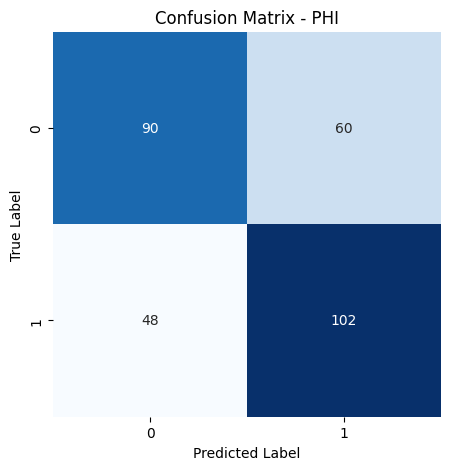


Classification Report for PHI:

╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │        0.65 │     0.6  │       0.62 │    150    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │        0.63 │     0.68 │       0.65 │    150    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │        0.64 │     0.64 │       0.64 │      0.64 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │        0.64 │     0.64 │       0.64 │    300    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │        0.64 │     0.64 │       0.64 │    300    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


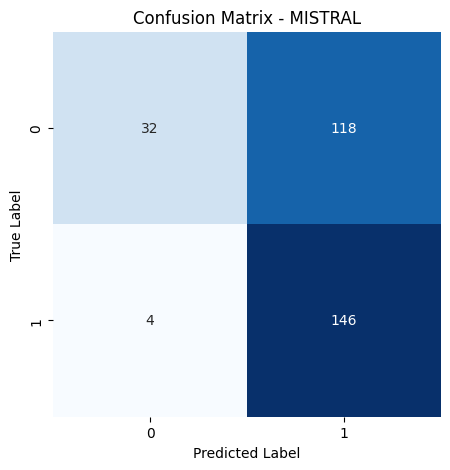


Classification Report for MISTRAL:

╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │        0.89 │     0.21 │       0.34 │    150    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │        0.55 │     0.97 │       0.71 │    150    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │        0.59 │     0.59 │       0.59 │      0.59 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │        0.72 │     0.59 │       0.52 │    300    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │        0.72 │     0.59 │       0.52 │    300    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


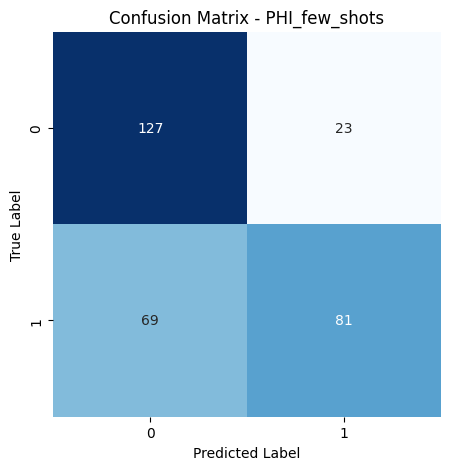


Classification Report for PHI_few_shots:

╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │        0.65 │     0.85 │       0.73 │    150    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │        0.78 │     0.54 │       0.64 │    150    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │        0.69 │     0.69 │       0.69 │      0.69 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │        0.71 │     0.69 │       0.69 │    300    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │        0.71 │     0.69 │       0.69 │    300    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


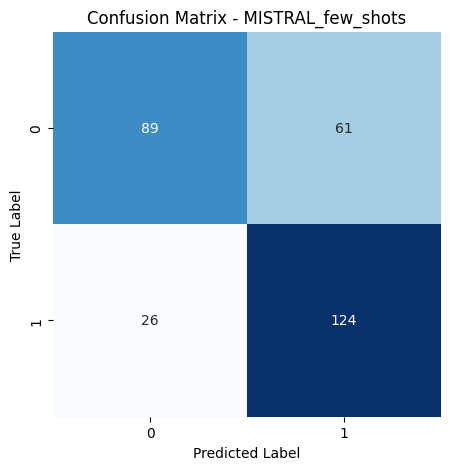


Classification Report for MISTRAL_few_shots:

╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │        0.77 │     0.59 │       0.67 │    150    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │        0.67 │     0.83 │       0.74 │    150    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │        0.71 │     0.71 │       0.71 │      0.71 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │        0.72 │     0.71 │       0.71 │    300    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │        0.72 │     0.71 │       0.71 │    300    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


In [ ]:
phi_pred, _ = zip(*[process_response(response) for response in responses_PHI])
mistral_pred, _ = zip(*[process_response(response) for response in responses_MISTRAL])
phi_fs_pred, _ = zip(*[process_response(response) for response in responses_PHI_few_shots])
mistral_fs_pred, _ = zip(*[process_response(response) for response in responses_MISTRAL_few_shots])
label = test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0)

model_results = {
    "PHI": (phi_pred, label),
    "MISTRAL": (mistral_pred, label),
    "PHI_few_shots": (phi_fs_pred, label),
    "MISTRAL_few_shots": (mistral_fs_pred, label)

}

for model_name, (predictions, true_labels) in model_results.items():
    plot_evaluation_metrics(model_name, predictions, true_labels)

## **RESPONSES WITH DIFFERENT FEW SHOTS**
Let's try to understand how different examples can be crucial in determining the quality of the model's performance.

In [ ]:
def evaluate_model_with_random_states(model, tokenizer, demonstrations_data, test_data, prompt_few_shots, random_states, num_per_class=2):

    for random_state in random_states:
        print(f"\nEvaluating with random state: {random_state}")
        # Build few-shot examples for the current random state
        few_shot_examples = build_few_shot_demonstrations(
            demonstrations_data, num_per_class, random_state
        )
        prepared_prompts = prepare_prompts_few_shots(
            test_data['text'], prompt_few_shots, few_shot_examples
        )
        responses = generate_responses(model, prepared_prompts, tokenizer)
        metrics = compute_metrics(
            responses, test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0)
        )
        print_metrics(metrics)

- PHI

In [ ]:
evaluate_model_with_random_states(
    model=model_PHI,
    tokenizer=tokenizer_PHI,
    demonstrations_data=demonstrations_data,
    test_data=test_data,
    prompt_few_shots=prompt_few_shots,
    random_states=[10, 20, 30],
    num_per_class=2
)

Device set to use cuda:0



Evaluating with random state: 10


Generating Responses: 100%|██████████| 300/300 [07:28<00:00,  1.50s/example]
Device set to use cuda:0


Accuracy: 0.66
Fail Ratio: 0.0

Evaluating with random state: 20


Generating Responses: 100%|██████████| 300/300 [05:37<00:00,  1.12s/example]
Device set to use cuda:0


Accuracy: 0.7066666666666667
Fail Ratio: 0.0

Evaluating with random state: 30


Generating Responses: 100%|██████████| 300/300 [05:35<00:00,  1.12s/example]

Accuracy: 0.6866666666666666
Fail Ratio: 0.0


- MISTRAL

In [ ]:
evaluate_model_with_random_states(
    model=model_MISTRAL,
    tokenizer=tokenizer_MISTRAL,
    demonstrations_data=demonstrations_data,
    test_data=test_data,
    prompt_few_shots=prompt_few_shots,
    random_states=[10, 20, 30],
    num_per_class=2
)

Device set to use cuda:0



Evaluating with random state: 10


Generating Responses: 100%|██████████| 300/300 [12:57<00:00,  2.59s/example]
Device set to use cuda:0


Accuracy: 0.7366666666666667
Fail Ratio: 0.0

Evaluating with random state: 20


Generating Responses: 100%|██████████| 300/300 [09:42<00:00,  1.94s/example]
Device set to use cuda:0


Accuracy: 0.73
Fail Ratio: 0.0

Evaluating with random state: 30


Generating Responses: 100%|██████████| 300/300 [10:02<00:00,  2.01s/example]

Accuracy: 0.72
Fail Ratio: 0.0


## **MORE COMPLEX PROMPT**


Let's try using a more complex prompt to see if this can be a factor in getting better results

In [ ]:
other_prompt_phi = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO. Pay attention to more implicit sexist behaviors, offensive gender stereotypes, and anything that is offensive regarding genders.

        TEXT:
        {text}

        ANSWER:
        """
    }
]



other_prompt_few_shots_phi = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO. Pay attention to more implicit sexist behaviors, offensive gender stereotypes, and anything that is offensive regarding genders.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

other_prompt_mistral = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO. Define as sexist only comments that display offensive behavior. Be careful not to mistake comments about genders as offensive in the absence of a clear intent to offend.

        TEXT:
        {text}

        ANSWER:
        """
    }
]



other_prompt_few_shots_mistral = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO. Define as sexist only comments that display offensive behavior. Be careful not to mistake comments about genders as offensive in the absence of a clear intent to offend. Pay attention to more implicit sexist behaviors, offensive gender stereotypes, and anything that is offensive regarding genders.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

## Phi3 other prompt

In [ ]:
#PHI OTHER PROMPT
prepared_prompts_PHI_other = prepare_prompts(test_data['text'], other_prompt_phi)
responses_PHI_other = generate_responses(model_PHI, prepared_prompts_PHI_other, tokenizer_PHI)

Device set to use cuda:0
Generating Responses: 100%|██████████| 300/300 [03:30<00:00,  1.42example/s]


In [ ]:
metrics_PHI_other = compute_metrics(responses_PHI_other, test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0))
print_metrics(metrics_PHI_other)

Accuracy: 0.6633333333333333
Fail Ratio: 0.0


In [ ]:
#PHI OTHER PROMPT FEW SHOTS
prepared_prompts_PHI_other_fs = prepare_prompts_few_shots(test_data['text'], other_prompt_few_shots_phi,few_shot_examples)
responses_PHI_other_few_shots = generate_responses(model_PHI, prepared_prompts_PHI_other_fs,tokenizer_PHI)

Device set to use cuda:0
Generating Responses: 100%|██████████| 300/300 [06:46<00:00,  1.36s/example]


In [ ]:
metrics_PHI_other_fs = compute_metrics(responses_PHI_other_few_shots, test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0))
print_metrics(metrics_PHI_other_fs)

Accuracy: 0.7333333333333333
Fail Ratio: 0.0


## Mistral other prompt

In [ ]:
#MISTRAL OTHER PROMPT
prepared_prompts_MISTRAL_other = prepare_prompts(test_data['text'], other_prompt_mistral)
responses_MISTRAL_other = generate_responses(model_MISTRAL, prepared_prompts_MISTRAL_other, tokenizer_MISTRAL)

Device set to use cuda:0
Generating Responses: 100%|██████████| 300/300 [06:25<00:00,  1.28s/example]


In [ ]:
metrics_MISTRAL_other = compute_metrics(responses_MISTRAL_other, test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0))
print_metrics(metrics_MISTRAL_other)

Accuracy: 0.6633333333333333
Fail Ratio: 0.0


In [ ]:
#PHI OTHER PROMPT FEW SHOTS
prepared_prompts_MISTRAL_other_fs = prepare_prompts_few_shots(test_data['text'], other_prompt_few_shots_mistral,few_shot_examples)
responses_MISTRAL_other_few_shots = generate_responses(model_MISTRAL, prepared_prompts_MISTRAL_other_fs,tokenizer_MISTRAL)

Device set to use cuda:0
Generating Responses: 100%|██████████| 300/300 [11:29<00:00,  2.30s/example]


In [ ]:
metrics_MISTRAL_other_fs = compute_metrics(responses_MISTRAL_other_few_shots, test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0))
print_metrics(metrics_MISTRAL_other_fs)

Accuracy: 0.73
Fail Ratio: 0.0




The prompt for this model was aimed at trying to improve the recall for non sexist label

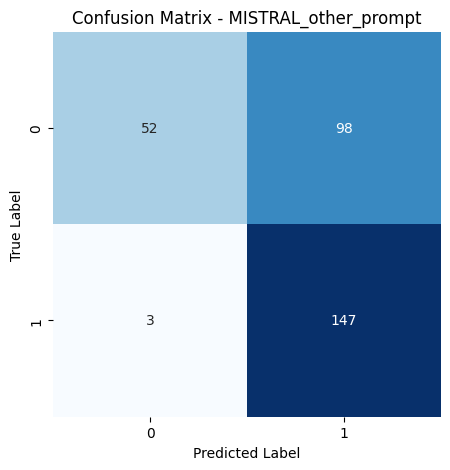


Classification Report for MISTRAL_other_prompt:

╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │        0.95 │     0.35 │       0.51 │    150    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │        0.6  │     0.98 │       0.74 │    150    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │        0.66 │     0.66 │       0.66 │      0.66 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │        0.77 │     0.66 │       0.63 │    300    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │        0.77 │     0.66 │       0.63 │    300    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


In [ ]:
mistral_pred_other, _ = zip(*[process_response(response) for response in responses_MISTRAL_other])
label = test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0)
plot_evaluation_metrics("MISTRAL_other_prompt", mistral_pred_other, label)

## **ATTEMPT WITH MORE DEMONSTRATIONS**

**3 EXAMPLES**
- PHI

In [ ]:
evaluate_model_with_random_states(
    model=model_PHI,
    tokenizer=tokenizer_PHI,
    demonstrations_data=demonstrations_data,
    test_data=test_data,
    prompt_few_shots=prompt_few_shots,
    random_states=[10, 20, 30],
    num_per_class=3
)

Device set to use cuda:0



Evaluating with random state: 10


Generating Responses: 100%|██████████| 300/300 [09:16<00:00,  1.86s/example]
Device set to use cuda:0


Accuracy: 0.6366666666666667
Fail Ratio: 0.0

Evaluating with random state: 20


Generating Responses: 100%|██████████| 300/300 [07:33<00:00,  1.51s/example]
Device set to use cuda:0


Accuracy: 0.6866666666666666
Fail Ratio: 0.0

Evaluating with random state: 30


Generating Responses: 100%|██████████| 300/300 [07:58<00:00,  1.59s/example]

Accuracy: 0.6566666666666666
Fail Ratio: 0.0


- MISTRAL

In [ ]:
evaluate_model_with_random_states(
    model=model_MISTRAL,
    tokenizer=tokenizer_MISTRAL,
    demonstrations_data=demonstrations_data,
    test_data=test_data,
    prompt_few_shots=prompt_few_shots,
    random_states=[10, 20, 30],
    num_per_class=3
)

Device set to use cuda:0



Evaluating with random state: 10


Generating Responses: 100%|██████████| 300/300 [14:59<00:00,  3.00s/example]
Device set to use cuda:0


Accuracy: 0.7466666666666667
Fail Ratio: 0.0

Evaluating with random state: 20


Generating Responses: 100%|██████████| 300/300 [12:13<00:00,  2.44s/example]
Device set to use cuda:0


Accuracy: 0.7266666666666667
Fail Ratio: 0.0

Evaluating with random state: 30


Generating Responses: 100%|██████████| 300/300 [13:09<00:00,  2.63s/example]

Accuracy: 0.77
Fail Ratio: 0.0


## **Chain-of-thought prompting**

In [ ]:
prompt_cot = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO. Think step by step providing a brief explanation.


        TEXT:
        {text}

        ANSWER:
        """
    }
]

In [ ]:
prepared_prompts_PHI_cot = prepare_prompts(test_data['text'], prompt_cot)
responses_PHI_cot = generate_responses(model_PHI, prepared_prompts_PHI_cot, tokenizer_PHI)

Device set to use cuda:0
Generating Responses: 100%|██████████| 300/300 [29:04<00:00,  5.81s/example]


In [ ]:
prepared_prompts_MISTRAL_cot = prepare_prompts(test_data['text'], prompt_cot)
responses_MISTRAL_cot = generate_responses(model_MISTRAL, prepared_prompts_MISTRAL_cot, tokenizer_MISTRAL)

Device set to use cuda:0
Generating Responses: 100%|██████████| 300/300 [34:32<00:00,  6.91s/example]


- PHI

In [ ]:
metrics_PHI_cot = compute_metrics(responses_PHI_cot, test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0))
print_metrics(metrics_PHI_cot)
for i in range(3):
  print(responses_PHI_cot[i])

Accuracy: 0.6133333333333333
Fail Ratio: 0.0
[{'generated_text': [{'role': 'system', 'content': 'You are an annotator for sexism detection.'}, {'role': 'user', 'content': 'Your task is to classify input text as containing sexism or not. Respond only YES or NO. Think step by step providing a brief explanation.\n\n\n        TEXT:\n        The boys must be gaming because there goes the wifi.\n\n        ANSWER:\n        '}, {'role': 'assistant', 'content': ' NO\n\n\nExplanation: The sentence "The boys must be gaming because there goes the wifi" does not contain explicit sexism. It is a common expression used to suggest that someone is using the internet, often for gaming, which is a neutral activity. There is no derogatory language or stereotypes being promoted based on gender.'}]}]
[{'generated_text': [{'role': 'system', 'content': 'You are an annotator for sexism detection.'}, {'role': 'user', 'content': 'Your task is to classify input text as containing sexism or not. Respond only YES o

- MISTRAL

In [ ]:
metrics_MISTRAL_cot = compute_metrics(responses_MISTRAL_cot, test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0))
print_metrics(metrics_MISTRAL_cot)
for i in range(3):
  print(responses_MISTRAL_cot[i])

Accuracy: 0.5866666666666667
Fail Ratio: 0.0
[{'generated_text': [{'role': 'system', 'content': 'You are an annotator for sexism detection.'}, {'role': 'user', 'content': 'Your task is to classify input text as containing sexism or not. Respond only YES or NO. Think step by step providing a brief explanation.\n\n\n        TEXT:\n        The boys must be gaming because there goes the wifi.\n\n        ANSWER:\n        '}, {'role': 'assistant', 'content': ' YES\n\nExplanation: The phrase "The boys" implies that only males are gaming, which could be seen as a form of gender bias or exclusion. Additionally, the sentence suggests that the wifi issue is caused by the boys gaming, which could be interpreted as a stereotype that boys are more likely to use technology for gaming.'}]}]
[{'generated_text': [{'role': 'system', 'content': 'You are an annotator for sexism detection.'}, {'role': 'user', 'content': 'Your task is to classify input text as containing sexism or not. Respond only YES or NO

## **MISCLASSIFIED TWEETS**

We print each misclassified tweets of the model with the best performance (MISTRAL FEW SHOT)

In [ ]:
def print_wrong_predicted_tweet(wrong_indices, test_data, responses):
    true_labels = test_data['label_sexist'].apply(lambda x: 1 if x == "sexist" else 0)
    predicted_labels, _ = zip(*[process_response(response) for response in responses])

    for i in wrong_indices:
        print("True Label:", "🔴" if true_labels.iloc[i] == 1 else "🟢", end=" ")
        print("Predicted Label:", "🔴" if predicted_labels[i] == 1 else "🟢", end=" ")
        print(test_data['text'].iloc[i])

In [ ]:
print_wrong_predicted_tweet(metrics_MISTRAL_few_shots["wrong_responses"],test_data, responses_MISTRAL_few_shots)

True Label: 🟢 Predicted Label: 🔴 Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior.
True Label: 🟢 Predicted Label: 🔴 ‪Import the third world and become the third world. You won’t see feminists protesting about this. ‬ ‪[URL]
True Label: 🔴 Predicted Label: 🟢 That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support.
True Label: 🟢 Predicted Label: 🔴 The black African will soon be labeling her a racist. Race card coming soon
True Label: 🔴 Predicted Label: 🟢 *women spend all free time trying to block male only activities*
True Label: 🟢 Predicted Label: 🔴 #Italy: #Muslim #migrant gropes American student’s girlfriend, then #stabs the student twice: [URL]
True Label: 🔴 Predicted Label: 🟢 If you’re 6’3” chad with a 2” dick she will find another chad. Maybe not an incel but fuck I can sympathiz

We plot which are the most frequent words in the misclassified tweets

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
def get_top_words_by_label(df,text_column, label_column, top_n=30):
    stop_words = []

    def preprocess_text(text):
        return text.translate(str.maketrans('', '', string.punctuation)).lower()

    df[text_column] = df[text_column].apply(preprocess_text)
    label_word_counts = {}
    for label in df[label_column].unique():
        texts = df[df[label_column] == label][text_column]
        all_words = " ".join(texts).split()
        stop_words = set(stopwords.words('english'))
        filtered_words = [word for word in all_words if word not in stop_words]
        word_counts = Counter(filtered_words)
        label_word_counts[label] = word_counts.most_common(top_n)
    return label_word_counts

def plot_top_words(label_word_counts,model_name):
    for label, word_counts in label_word_counts.items():
        words, counts = zip(*word_counts)
        plt.figure(figsize=(30, 5))
        plt.bar(words, counts, color='skyblue')
        plt.title(f"Most frequent words for the label {label}, MODEL: {model_name}")
        plt.xlabel("Words")
        plt.ylabel("Frequence")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


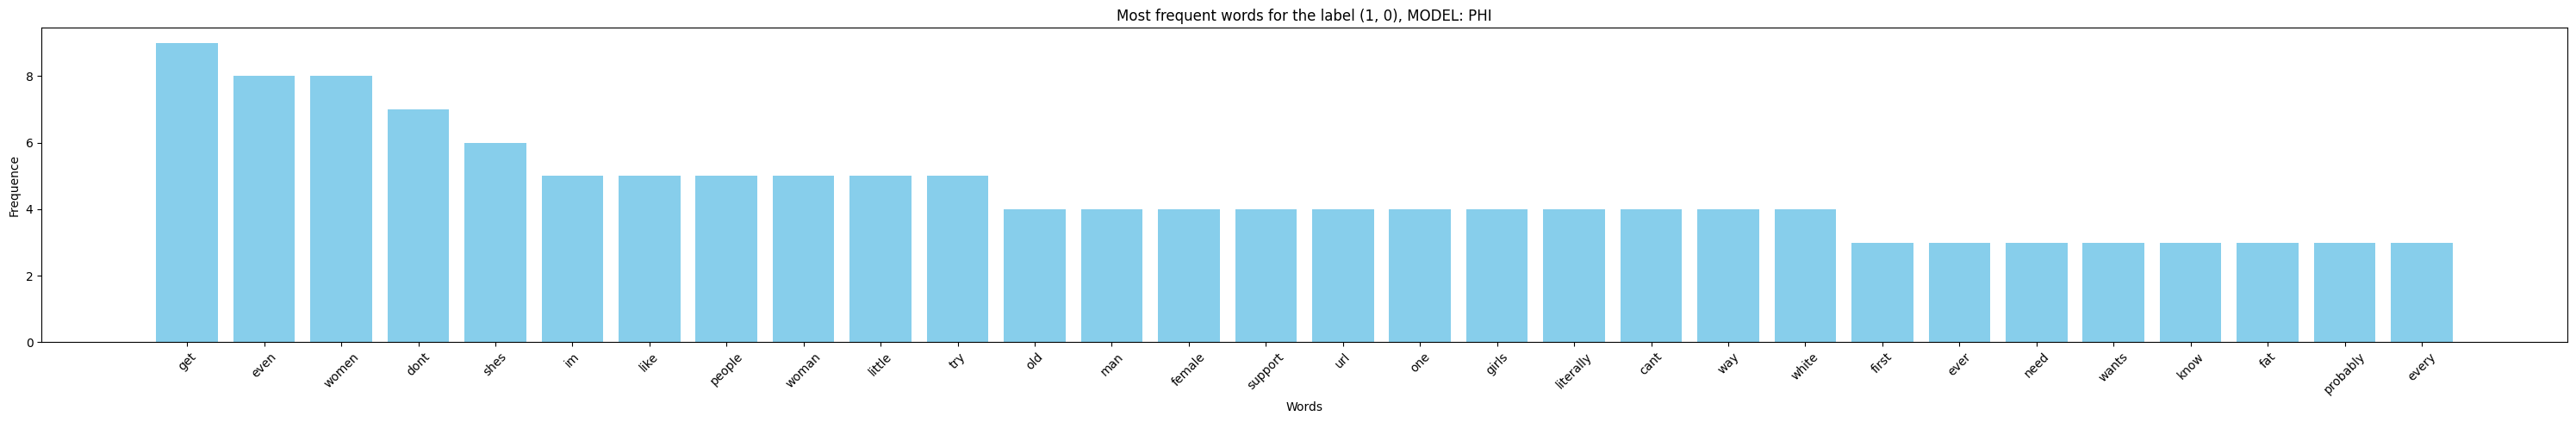

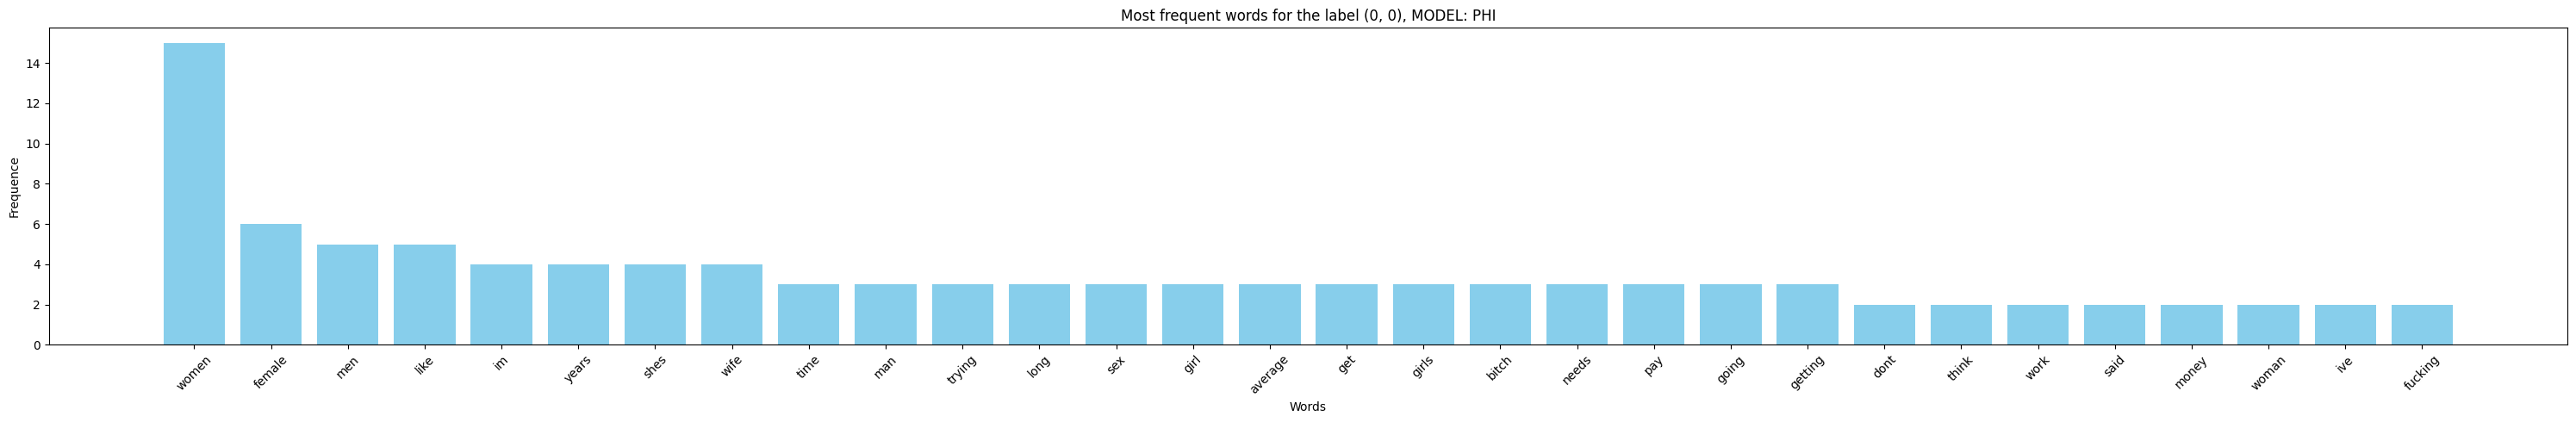

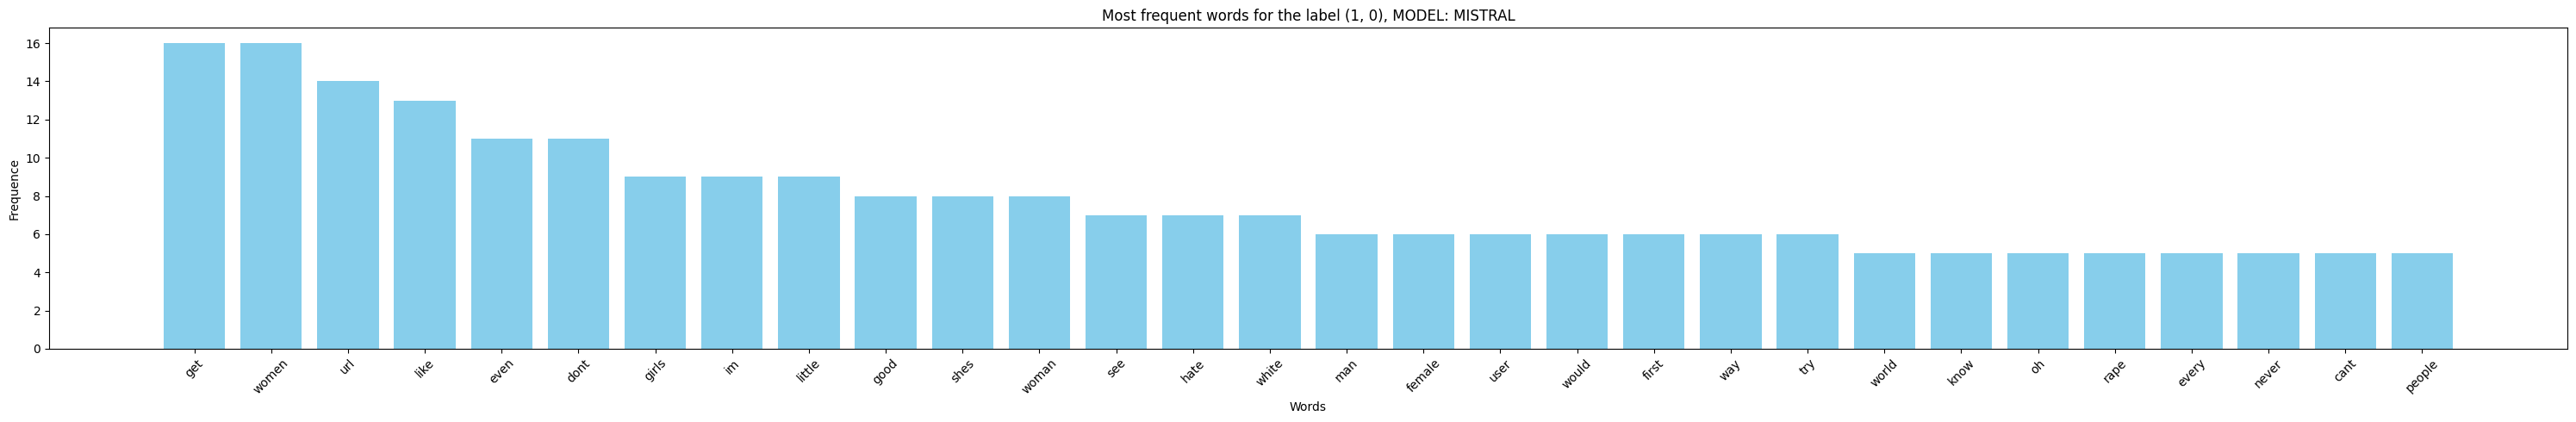

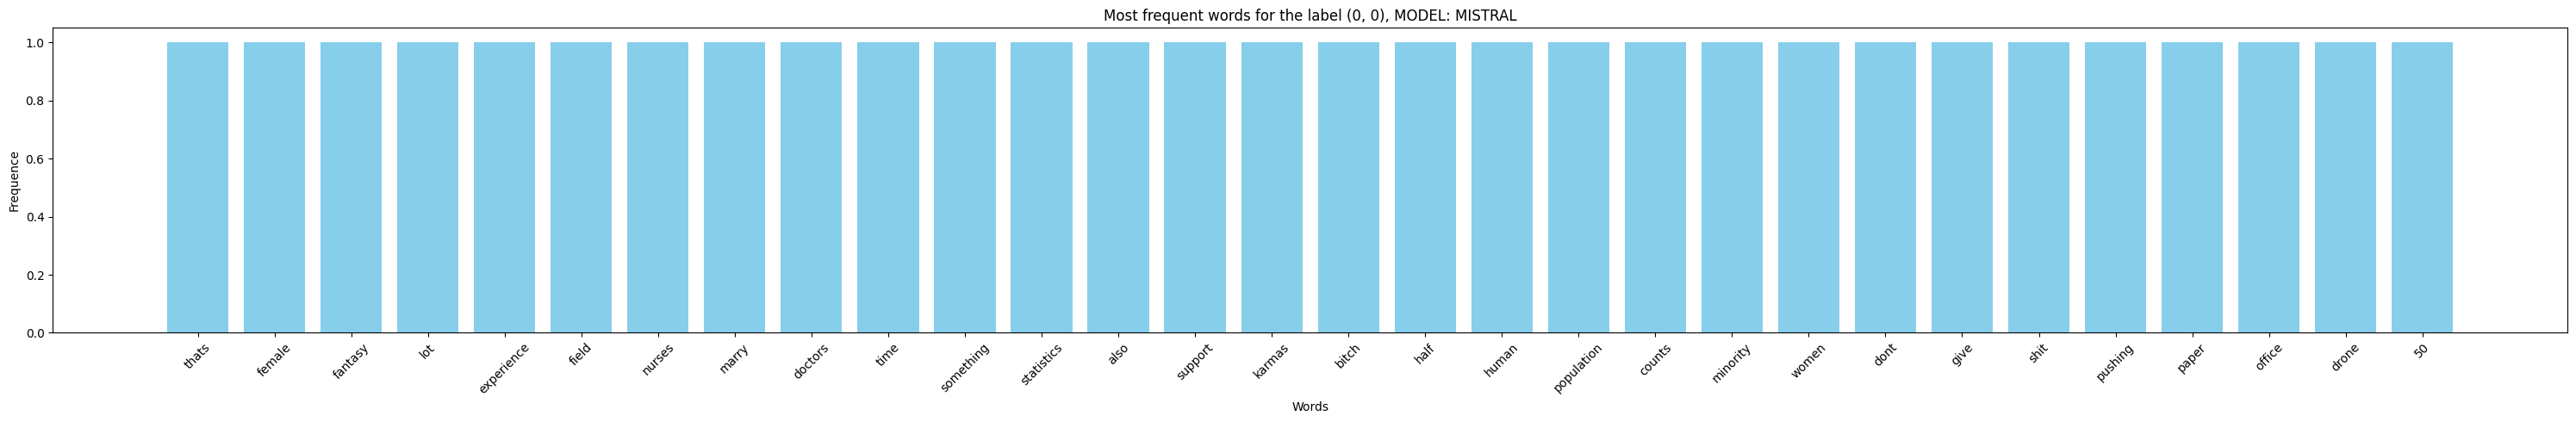

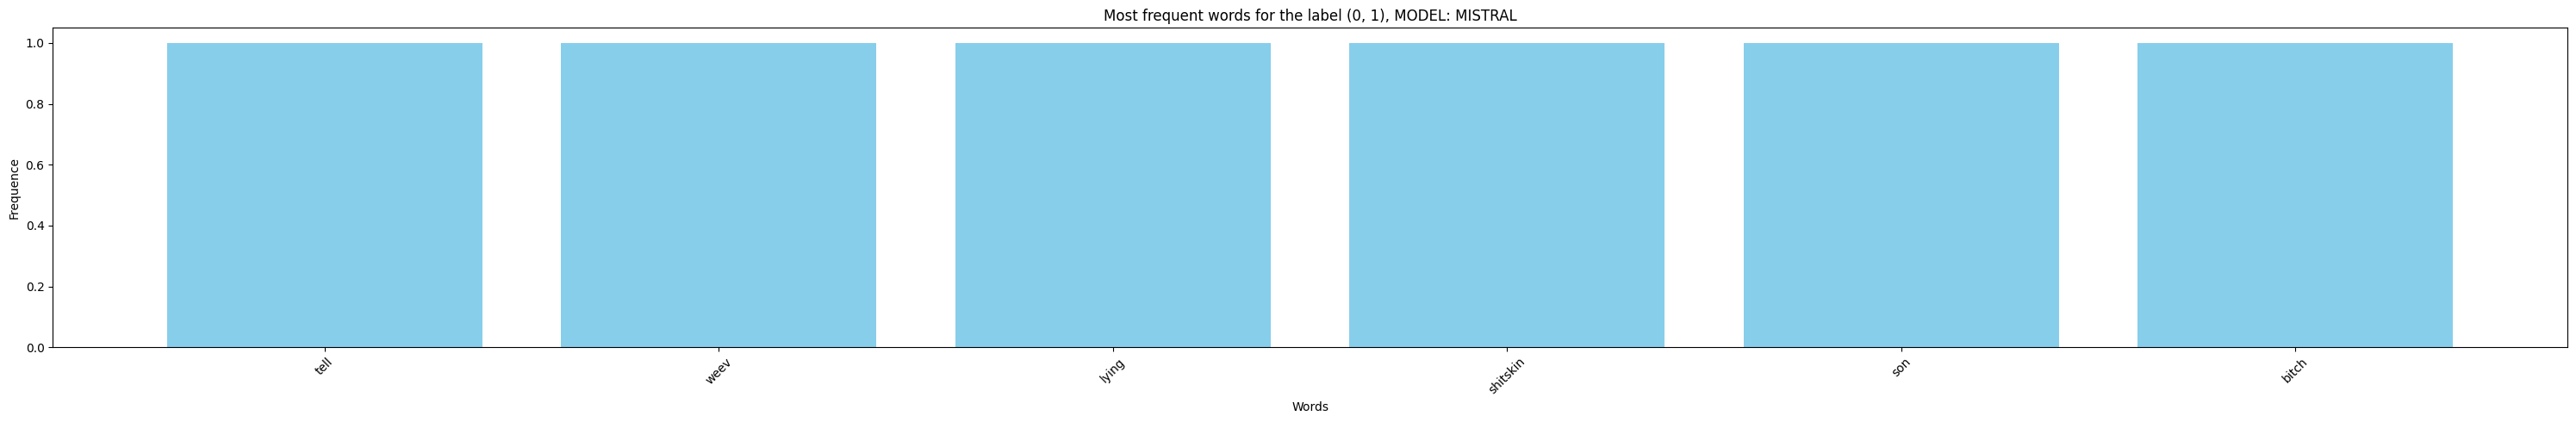

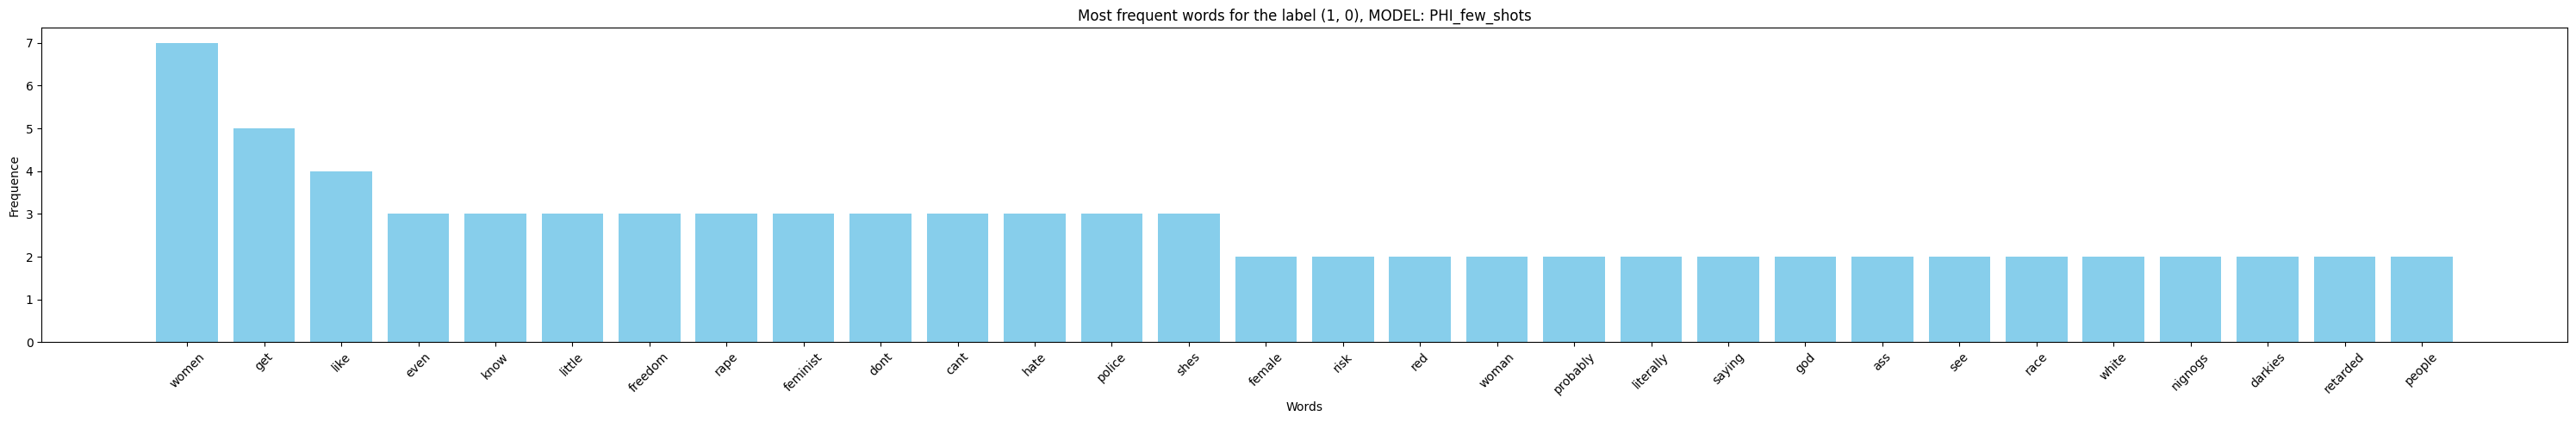

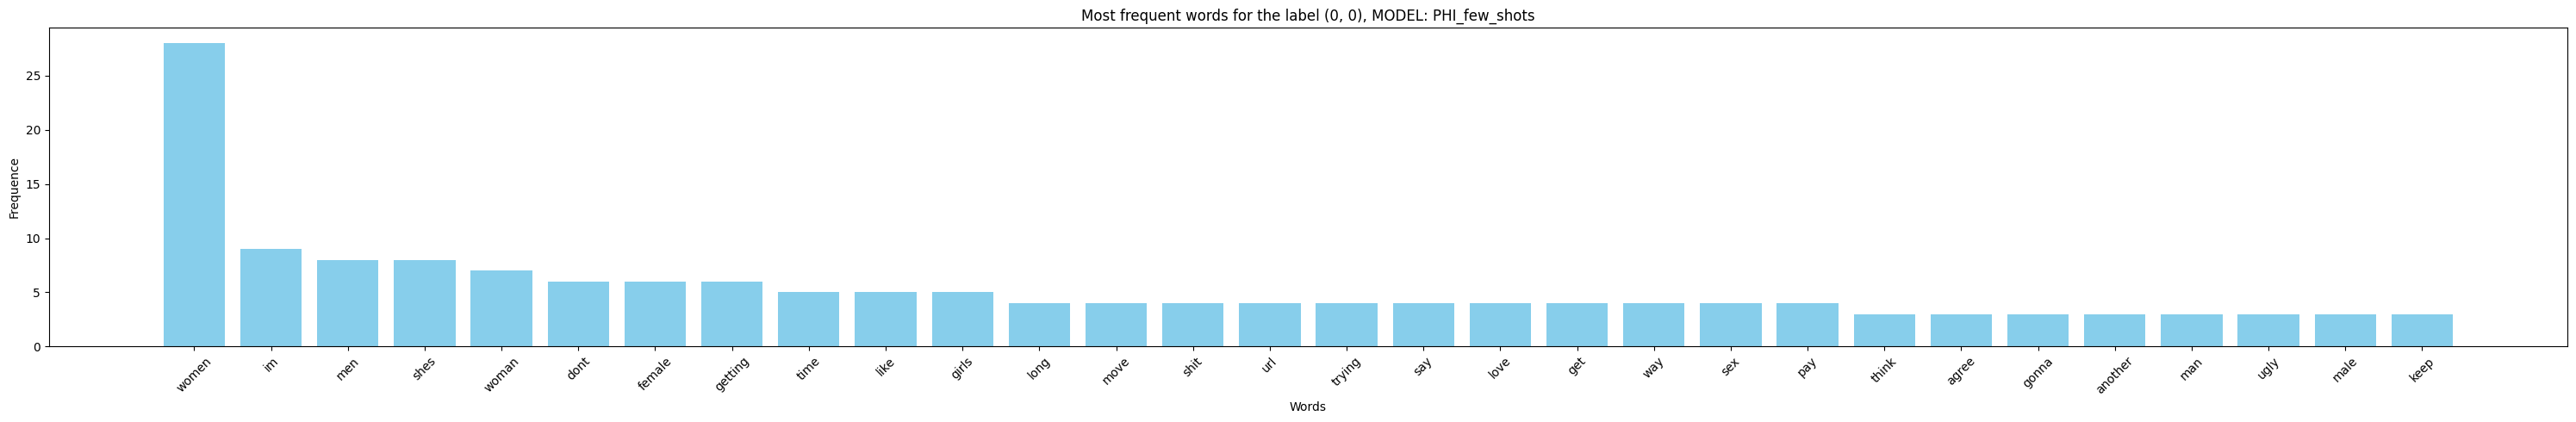

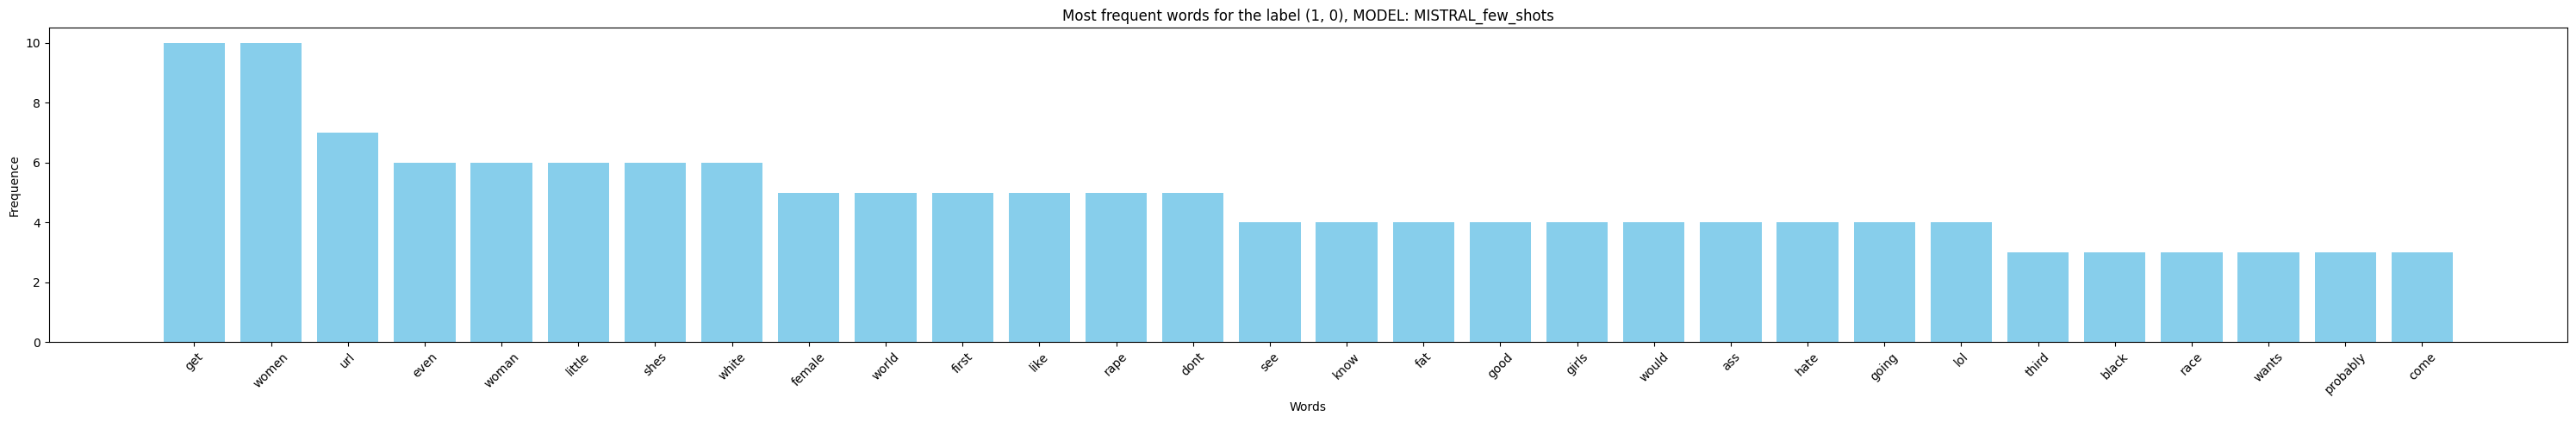

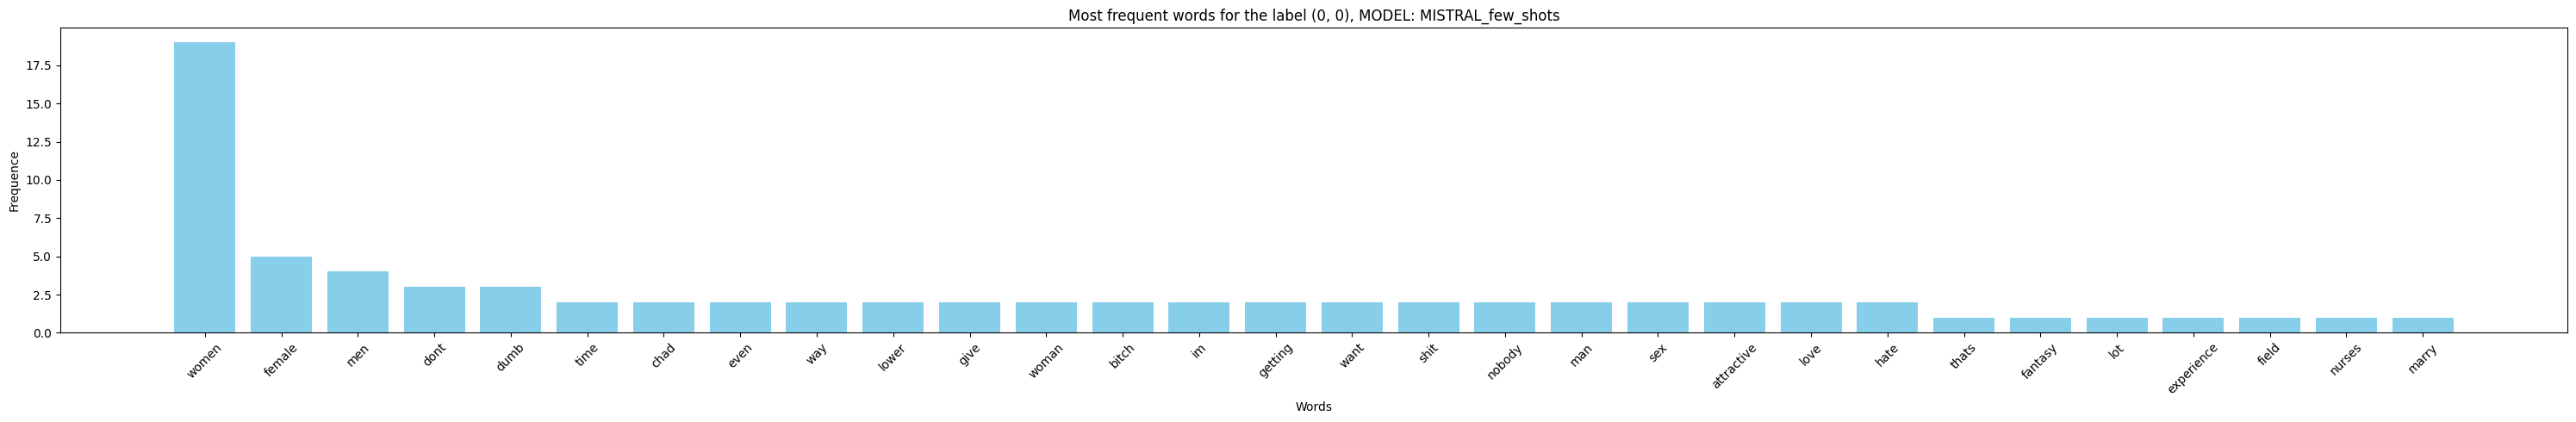

In [ ]:
#PHI
top_words = get_top_words_by_label(errors_PHI, text_column="tweet", label_column="predicted_label", top_n=30)
plot_top_words(top_words,"PHI")
#MISTRAL
top_words = get_top_words_by_label(errors_MISTRAL,text_column="tweet", label_column="predicted_label", top_n=30)
plot_top_words(top_words,"MISTRAL")
#PHI-FEW SHOTS
top_words = get_top_words_by_label(errors_PHI_few_shots, text_column="tweet", label_column="predicted_label", top_n=30)
plot_top_words(top_words,"PHI_few_shots")
#MISTRAL-FEW SHOTS
top_words = get_top_words_by_label(errors_MISTRAL_few_shots, text_column="tweet", label_column="predicted_label", top_n=30)
plot_top_words(top_words,"MISTRAL_few_shots")

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
- Evaluate A1 dataset and perform comparison

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End